In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [13]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥1.0.2 is required
import sklearn
assert sklearn.__version__ >= "1.0.2"

# Common imports
import numpy as np
import os
import pandas as pd
import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)


# Load and process data

In [14]:
# read data from csv file
trainset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/trainset.csv')
testset = pd.read_csv('../datasets/dataset_MonteCarlo_100.000/testset.csv')
print(trainset.shape)
print(testset.shape)

(80000, 15)
(20000, 15)


In [15]:
trainset

,0_Ca,0_Cl,0_Na,0_K,0_N5,1_Ca,1_Cl,1_Na,1_K,1_N5,out_Ca,out_Cl,out_Na,out_K,out_N5
0,0.341575,1.159034,0.012636,0.451710,0.794808,0.347226,0.116634,0.755911,0.674340,1.359338,0.3233,1.1590,0.02901,0.4719,0.79480
1,0.638607,0.558054,1.231009,0.243433,1.132821,0.038278,0.185744,0.734268,1.464984,1.489907,0.4584,0.5581,1.24700,0.5882,1.13300
2,0.787981,0.763241,0.349968,0.738449,1.452716,1.117356,0.110285,0.393380,0.282715,1.466671,0.8053,0.7632,0.34980,0.7038,1.45300
3,0.466115,0.948450,0.942671,1.051085,1.358636,0.470234,0.252135,0.914662,1.318543,1.076570,0.4558,0.9484,0.94180,1.0730,1.35900
4,0.452663,0.644895,1.360873,0.991130,0.162887,1.361588,1.475943,0.637112,0.397679,1.414160,0.4939,0.6449,1.34300,0.9266,0.16290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0.796601,0.398041,1.132371,0.996845,0.094560,1.074895,1.055513,0.777877,0.870241,0.361988,0.8083,0.3980,1.12600,0.9802,0.09456
79996,0.942419,1.456538,1.164360,0.775981,0.069458,1.024540,1.025283,0.144121,1.438743,0.241862,0.9305,1.4570,1.15000,0.8141,0.06946
79997,1.095302,0.438446,1.335379,0.365207,0.273701,0.765942,0.880543,1.152310,1.119219,1.104459,1.0670,0.4384,1.33500,0.4223,0.27370
79998,0.310626,0.661302,0.192742,1.280823,0.931653,0.199012,0.072267,0.870017,0.563615,0.006399,0.3275,0.6613,0.21380,1.2260,0.93170


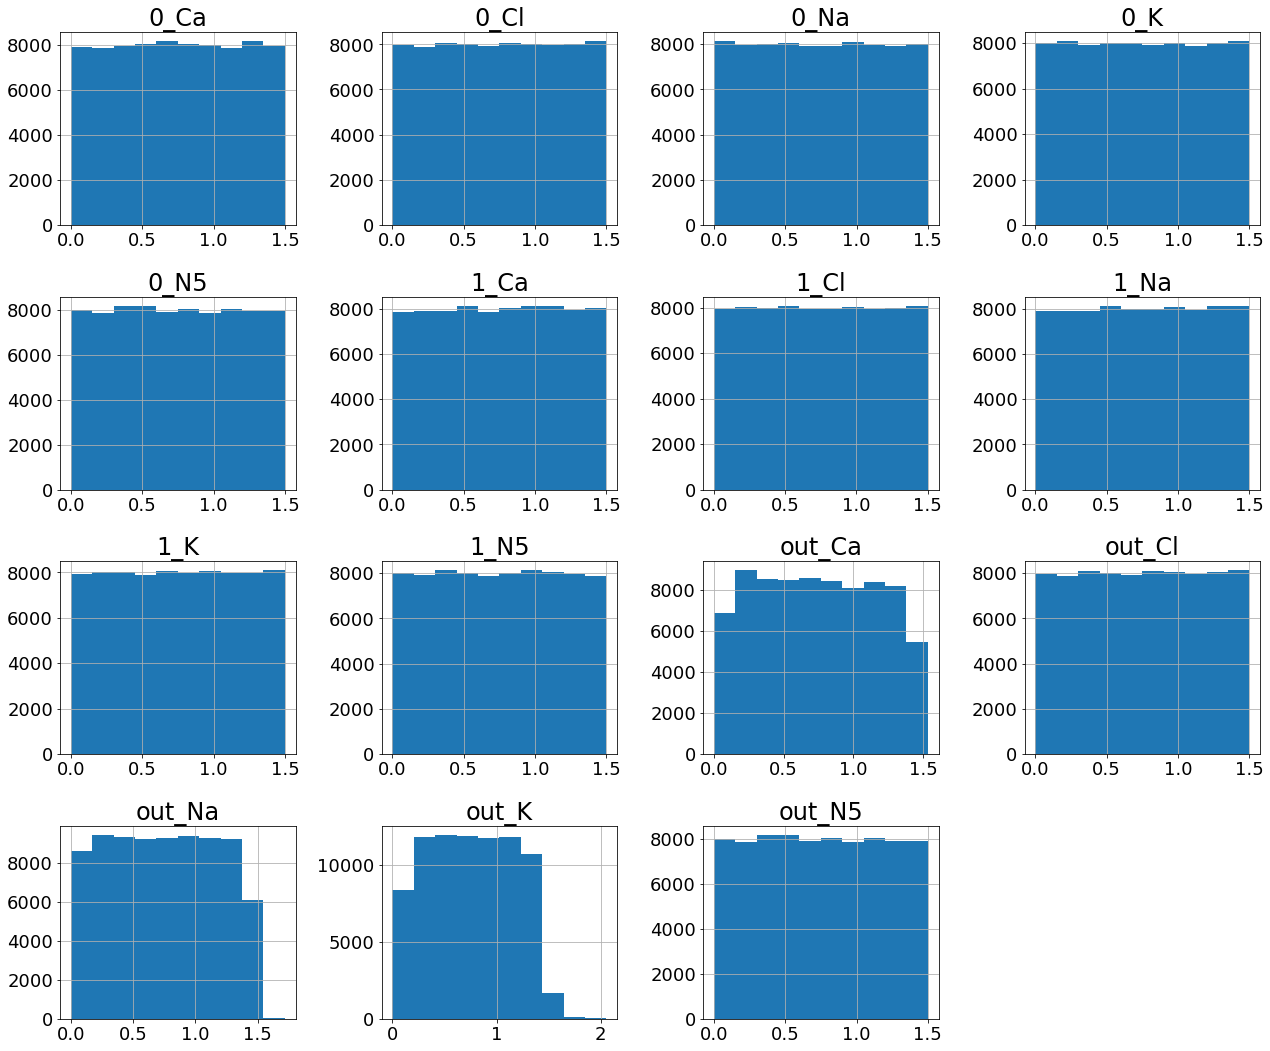

In [16]:
trainset.hist(figsize=(18, 15));
plt.tight_layout()

In [17]:
# split x and y
X_train = trainset.iloc[:, [0,2,3,5,7,8]].values 
y_train = trainset.iloc[:, [10, 12, 13]].values
X_test = testset.iloc[:, [0,2,3,5,7,8]].values 
y_test = testset.iloc[:, [10, 12, 13]].values

# Name variables
inputs = [list(trainset)[i] for i in [0,2,3,5,7,8]] 
outputs = [list(trainset)[i] for i in [10, 12, 13]] # do not work for list -> list(trainset)[10, 12, 13]

In [18]:
print('Inputs: ', inputs)
print('Outputs: ', outputs)
print('X_train instances: ', X_train.shape)
print('X_test instances: ', X_test.shape)
print('y_train instances: ', y_train.shape)
print('y_test instances: ', y_test.shape)

Inputs:  ['0_Ca', '0_Na', '0_K', '1_Ca', '1_Na', '1_K']
Outputs:  ['out_Ca', 'out_Na', 'out_K']
X_train instances:  (80000, 6)
X_test instances:  (20000, 6)
y_train instances:  (80000, 3)
y_test instances:  (20000, 3)


## Normalize data

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

norm_pipeline = Pipeline([
        ('minmax_scaler', MinMaxScaler((-1,1))),
    ])

X_train_norm = norm_pipeline.fit_transform(X_train)
X_test_norm = norm_pipeline.transform(X_test)

# Fine Tuning

## Tensorflow NN

In [20]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import RMSprop, Adam

print(tf.__version__)

2.4.1


In [21]:
INPUT_SIZE = 6
OUTPUT_SIZE = 3

# Model
def create_model(hiden_layers, neurons, dropout, kreg, activation, lactivation, lr):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(INPUT_SIZE,), activation=activation, kernel_regularizer=l2(kreg)))
    if dropout >1e-3:
        model.add(Dropout(dropout))
    for i in range(hiden_layers):
        model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(kreg)))
        if dropout >1e-3:
            model.add(Dropout(dropout))
    model.add(Dense(OUTPUT_SIZE, activation=lactivation))

    model.compile(loss='mean_squared_error',
                  optimizer= Adam(lr), # rmsprop, adam, sgd, adagrad
                  metrics=['mean_squared_error'])
    return model

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=1000,
                                               verbose=10,
                                               restore_best_weights=True)

### No PINN

In [22]:
# for reproducibility
tf.random.set_seed(42) 
np.random.seed(42)

start = time.time()
# hiden_layers, neurons, dropout, kreg, activation, lactivation, lr, pinn_weight
#
# Best from Gridsearch_NeuralNetwork
#
model = create_model(1,256,0.0,1e-6,'relu','linear',1e-4)

history = model.fit(X_train_norm, 
          y_train, 
          epochs=1000, 
          batch_size=128,
          validation_split=0.2,
          callbacks = [early_stopping]
                   )

reg_best = model
print('\n\nTime: ',time.time()-start)

Epoch 1/1000
500/500 [==============================] - 4s 7ms/step - loss: 0.2210 - mean_squared_error: 0.2207 - val_loss: 0.0109 - val_mean_squared_error: 0.0107
Epoch 2/1000
500/500 [==============================] - 3s 6ms/step - loss: 0.0092 - mean_squared_error: 0.0090 - val_loss: 0.0043 - val_mean_squared_error: 0.0041
Epoch 3/1000
500/500 [==============================] - 4s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0026 - val_loss: 0.0011 - val_mean_squared_error: 7.9761e-04
Epoch 4/1000
500/500 [==============================] - 4s 9ms/step - loss: 9.0906e-04 - mean_squared_error: 6.4067e-04 - val_loss: 8.8805e-04 - val_mean_squared_error: 6.2020e-04
Epoch 5/1000
500/500 [==============================] - 3s 7ms/step - loss: 7.8372e-04 - mean_squared_error: 5.1612e-04 - val_loss: 8.1816e-04 - val_mean_squared_error: 5.5135e-04
Epoch 6/1000
500/500 [==============================] - 3s 6ms/step - loss: 7.0814e-04 - mean_squared_error: 4.4162e-04 - val_loss: 7.6642e-04 -

500/500 [==============================] - 3s 5ms/step - loss: 1.9911e-04 - mean_squared_error: 6.4568e-05 - val_loss: 2.3230e-04 - val_mean_squared_error: 9.9605e-05
Epoch 47/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.9429e-04 - mean_squared_error: 6.2220e-05 - val_loss: 2.3266e-04 - val_mean_squared_error: 1.0239e-04
Epoch 48/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.8885e-04 - mean_squared_error: 5.9174e-05 - val_loss: 2.3561e-04 - val_mean_squared_error: 1.0768e-04
Epoch 49/1000
500/500 [==============================] - 3s 7ms/step - loss: 1.8746e-04 - mean_squared_error: 6.0102e-05 - val_loss: 2.2033e-04 - val_mean_squared_error: 9.4679e-05
Epoch 50/1000
500/500 [==============================] - 4s 7ms/step - loss: 1.8806e-04 - mean_squared_error: 6.2970e-05 - val_loss: 2.1545e-04 - val_mean_squared_error: 9.2025e-05
Epoch 51/1000
500/500 [==============================] - 3s 6ms/step - loss: 1.7963e-04 - mean_squared_error:

500/500 [==============================] - 3s 6ms/step - loss: 9.5387e-05 - mean_squared_error: 3.0157e-05 - val_loss: 1.2149e-04 - val_mean_squared_error: 5.6914e-05
Epoch 92/1000
500/500 [==============================] - 3s 6ms/step - loss: 9.7784e-05 - mean_squared_error: 3.3419e-05 - val_loss: 1.2544e-04 - val_mean_squared_error: 6.1732e-05
Epoch 93/1000
500/500 [==============================] - 3s 7ms/step - loss: 9.7313e-05 - mean_squared_error: 3.3809e-05 - val_loss: 1.2816e-04 - val_mean_squared_error: 6.5297e-05
Epoch 94/1000
500/500 [==============================] - 3s 7ms/step - loss: 9.3830e-05 - mean_squared_error: 3.1165e-05 - val_loss: 1.1994e-04 - val_mean_squared_error: 5.7897e-05
Epoch 95/1000
500/500 [==============================] - 3s 7ms/step - loss: 9.2163e-05 - mean_squared_error: 3.0329e-05 - val_loss: 1.2135e-04 - val_mean_squared_error: 6.0119e-05
Epoch 96/1000
500/500 [==============================] - 3s 6ms/step - loss: 9.4712e-05 - mean_squared_error:

500/500 [==============================] - 3s 7ms/step - loss: 6.3284e-05 - mean_squared_error: 2.3332e-05 - val_loss: 8.7632e-05 - val_mean_squared_error: 4.7938e-05
Epoch 137/1000
500/500 [==============================] - 3s 6ms/step - loss: 5.9823e-05 - mean_squared_error: 2.0213e-05 - val_loss: 8.7078e-05 - val_mean_squared_error: 4.7710e-05
Epoch 138/1000
500/500 [==============================] - 3s 6ms/step - loss: 5.8227e-05 - mean_squared_error: 1.8957e-05 - val_loss: 8.6071e-05 - val_mean_squared_error: 4.7034e-05
Epoch 139/1000
500/500 [==============================] - 3s 6ms/step - loss: 6.2988e-05 - mean_squared_error: 2.4028e-05 - val_loss: 8.6232e-05 - val_mean_squared_error: 4.7537e-05
Epoch 140/1000
500/500 [==============================] - 3s 6ms/step - loss: 6.2013e-05 - mean_squared_error: 2.3386e-05 - val_loss: 9.1161e-05 - val_mean_squared_error: 5.2769e-05
Epoch 141/1000
500/500 [==============================] - 3s 6ms/step - loss: 6.4539e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 4.9582e-05 - mean_squared_error: 2.0009e-05 - val_loss: 7.1970e-05 - val_mean_squared_error: 4.2523e-05
Epoch 182/1000
500/500 [==============================] - 3s 6ms/step - loss: 4.4469e-05 - mean_squared_error: 1.5064e-05 - val_loss: 7.1641e-05 - val_mean_squared_error: 4.2323e-05
Epoch 183/1000
500/500 [==============================] - 3s 6ms/step - loss: 4.9945e-05 - mean_squared_error: 2.0669e-05 - val_loss: 7.2906e-05 - val_mean_squared_error: 4.3754e-05
Epoch 184/1000
500/500 [==============================] - 3s 6ms/step - loss: 5.1863e-05 - mean_squared_error: 2.2736e-05 - val_loss: 7.2276e-05 - val_mean_squared_error: 4.3269e-05
Epoch 185/1000
500/500 [==============================] - 3s 6ms/step - loss: 4.7364e-05 - mean_squared_error: 1.8389e-05 - val_loss: 7.0338e-05 - val_mean_squared_error: 4.1472e-05
Epoch 186/1000
500/500 [==============================] - 3s 6ms/step - loss: 4.4619e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 4.0037e-05 - mean_squared_error: 1.5546e-05 - val_loss: 5.7731e-05 - val_mean_squared_error: 3.3318e-05
Epoch 227/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.6777e-05 - mean_squared_error: 1.2388e-05 - val_loss: 7.6300e-05 - val_mean_squared_error: 5.1952e-05
Epoch 228/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.7831e-05 - mean_squared_error: 1.3501e-05 - val_loss: 6.3133e-05 - val_mean_squared_error: 3.8880e-05
Epoch 229/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.8712e-05 - mean_squared_error: 1.4475e-05 - val_loss: 6.1493e-05 - val_mean_squared_error: 3.7302e-05
Epoch 230/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.8995e-05 - mean_squared_error: 1.4830e-05 - val_loss: 6.3488e-05 - val_mean_squared_error: 3.9394e-05
Epoch 231/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.8259e-05 - mean_squared_e

500/500 [==============================] - 3s 5ms/step - loss: 3.8246e-05 - mean_squared_error: 1.6651e-05 - val_loss: 5.5119e-05 - val_mean_squared_error: 3.3573e-05
Epoch 272/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.3527e-05 - mean_squared_error: 1.1990e-05 - val_loss: 5.3560e-05 - val_mean_squared_error: 3.2056e-05
Epoch 273/1000
500/500 [==============================] - 2s 5ms/step - loss: 3.3642e-05 - mean_squared_error: 1.2158e-05 - val_loss: 6.4616e-05 - val_mean_squared_error: 4.3163e-05
Epoch 274/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.4907e-05 - mean_squared_error: 1.3459e-05 - val_loss: 6.4299e-05 - val_mean_squared_error: 4.2900e-05
Epoch 275/1000
500/500 [==============================] - 2s 5ms/step - loss: 3.6406e-05 - mean_squared_error: 1.5011e-05 - val_loss: 6.3439e-05 - val_mean_squared_error: 4.2084e-05
Epoch 276/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.3957e-05 - mean_squared_e

500/500 [==============================] - 3s 5ms/step - loss: 3.1306e-05 - mean_squared_error: 1.1586e-05 - val_loss: 5.7134e-05 - val_mean_squared_error: 3.7427e-05
Epoch 317/1000
500/500 [==============================] - 2s 5ms/step - loss: 3.1085e-05 - mean_squared_error: 1.1405e-05 - val_loss: 6.3945e-05 - val_mean_squared_error: 4.4267e-05
Epoch 318/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.7414e-05 - mean_squared_error: 1.7755e-05 - val_loss: 5.8246e-05 - val_mean_squared_error: 3.8629e-05
Epoch 319/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.0873e-05 - mean_squared_error: 1.1263e-05 - val_loss: 5.4006e-05 - val_mean_squared_error: 3.4428e-05
Epoch 320/1000
500/500 [==============================] - 2s 5ms/step - loss: 2.8292e-05 - mean_squared_error: 8.7195e-06 - val_loss: 5.3591e-05 - val_mean_squared_error: 3.4049e-05
Epoch 321/1000
500/500 [==============================] - 3s 5ms/step - loss: 3.1109e-05 - mean_squared_e

500/500 [==============================] - 3s 5ms/step - loss: 3.3424e-05 - mean_squared_error: 1.5088e-05 - val_loss: 5.0623e-05 - val_mean_squared_error: 3.2301e-05
Epoch 362/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9765e-05 - mean_squared_error: 1.1449e-05 - val_loss: 4.7691e-05 - val_mean_squared_error: 2.9394e-05
Epoch 363/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.8012e-05 - mean_squared_error: 9.7306e-06 - val_loss: 5.6647e-05 - val_mean_squared_error: 3.8384e-05
Epoch 364/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9800e-05 - mean_squared_error: 1.1537e-05 - val_loss: 4.5634e-05 - val_mean_squared_error: 2.7382e-05
Epoch 365/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9353e-05 - mean_squared_error: 1.1119e-05 - val_loss: 5.0765e-05 - val_mean_squared_error: 3.2552e-05
Epoch 366/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9939e-05 - mean_squared_e

500/500 [==============================] - 3s 7ms/step - loss: 2.8584e-05 - mean_squared_error: 1.1311e-05 - val_loss: 4.9578e-05 - val_mean_squared_error: 3.2328e-05
Epoch 407/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.6873e-05 - mean_squared_error: 9.6302e-06 - val_loss: 5.2274e-05 - val_mean_squared_error: 3.5031e-05
Epoch 408/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.7651e-05 - mean_squared_error: 1.0413e-05 - val_loss: 4.3805e-05 - val_mean_squared_error: 2.6597e-05
Epoch 409/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9103e-05 - mean_squared_error: 1.1899e-05 - val_loss: 5.5831e-05 - val_mean_squared_error: 3.8634e-05
Epoch 410/1000
500/500 [==============================] - 3s 6ms/step - loss: 3.0866e-05 - mean_squared_error: 1.3670e-05 - val_loss: 4.7488e-05 - val_mean_squared_error: 3.0306e-05
Epoch 411/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.9055e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 2.5585e-05 - mean_squared_error: 9.1231e-06 - val_loss: 4.7776e-05 - val_mean_squared_error: 3.1345e-05
Epoch 452/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.4745e-05 - mean_squared_error: 8.3175e-06 - val_loss: 4.6633e-05 - val_mean_squared_error: 3.0206e-05
Epoch 453/1000
500/500 [==============================] - 2s 5ms/step - loss: 2.4889e-05 - mean_squared_error: 8.4753e-06 - val_loss: 4.5100e-05 - val_mean_squared_error: 2.8698e-05
Epoch 454/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.5797e-05 - mean_squared_error: 9.4069e-06 - val_loss: 4.9661e-05 - val_mean_squared_error: 3.3287e-05
Epoch 455/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.7060e-05 - mean_squared_error: 1.0683e-05 - val_loss: 4.7036e-05 - val_mean_squared_error: 3.0676e-05
Epoch 456/1000
500/500 [==============================] - 2s 5ms/step - loss: 2.4882e-05 - mean_squared_e

500/500 [==============================] - 3s 7ms/step - loss: 2.5335e-05 - mean_squared_error: 9.6136e-06 - val_loss: 4.6996e-05 - val_mean_squared_error: 3.1302e-05
Epoch 497/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.4279e-05 - mean_squared_error: 8.5939e-06 - val_loss: 4.7667e-05 - val_mean_squared_error: 3.1984e-05
Epoch 498/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.6018e-05 - mean_squared_error: 1.0342e-05 - val_loss: 5.1335e-05 - val_mean_squared_error: 3.5667e-05
Epoch 499/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.6158e-05 - mean_squared_error: 1.0495e-05 - val_loss: 4.7751e-05 - val_mean_squared_error: 3.2087e-05
Epoch 500/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.5983e-05 - mean_squared_error: 1.0317e-05 - val_loss: 4.4707e-05 - val_mean_squared_error: 2.9066e-05
Epoch 501/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.8409e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 2.4464e-05 - mean_squared_error: 9.3701e-06 - val_loss: 4.5104e-05 - val_mean_squared_error: 3.0021e-05
Epoch 542/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.1942e-05 - mean_squared_error: 6.8715e-06 - val_loss: 5.5181e-05 - val_mean_squared_error: 4.0114e-05
Epoch 543/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.6785e-05 - mean_squared_error: 1.1716e-05 - val_loss: 5.1738e-05 - val_mean_squared_error: 3.6698e-05
Epoch 544/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.4963e-05 - mean_squared_error: 9.9156e-06 - val_loss: 4.8989e-05 - val_mean_squared_error: 3.3942e-05
Epoch 545/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.3004e-05 - mean_squared_error: 7.9589e-06 - val_loss: 7.6003e-05 - val_mean_squared_error: 6.0991e-05
Epoch 546/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.6791e-05 - mean_squared_e

500/500 [==============================] - 3s 5ms/step - loss: 2.4318e-05 - mean_squared_error: 9.7557e-06 - val_loss: 4.4166e-05 - val_mean_squared_error: 2.9620e-05
Epoch 587/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.2404e-05 - mean_squared_error: 7.8657e-06 - val_loss: 3.9850e-05 - val_mean_squared_error: 2.5318e-05
Epoch 588/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.4225e-05 - mean_squared_error: 9.6966e-06 - val_loss: 4.3123e-05 - val_mean_squared_error: 2.8599e-05
Epoch 589/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.2119e-05 - mean_squared_error: 7.6101e-06 - val_loss: 5.2143e-05 - val_mean_squared_error: 3.7656e-05
Epoch 590/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.7625e-05 - mean_squared_error: 1.3113e-05 - val_loss: 4.1259e-05 - val_mean_squared_error: 2.6764e-05
Epoch 591/1000
500/500 [==============================] - 3s 5ms/step - loss: 2.3825e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 2.5057e-05 - mean_squared_error: 1.0996e-05 - val_loss: 5.0384e-05 - val_mean_squared_error: 3.6314e-05
Epoch 632/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.4833e-05 - mean_squared_error: 1.0770e-05 - val_loss: 5.9156e-05 - val_mean_squared_error: 4.5102e-05
Epoch 633/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.2749e-05 - mean_squared_error: 8.7003e-06 - val_loss: 5.0421e-05 - val_mean_squared_error: 3.6378e-05
Epoch 634/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.1452e-05 - mean_squared_error: 7.4101e-06 - val_loss: 4.6938e-05 - val_mean_squared_error: 3.2911e-05
Epoch 635/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.3494e-05 - mean_squared_error: 9.4623e-06 - val_loss: 4.3258e-05 - val_mean_squared_error: 2.9246e-05
Epoch 636/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.1428e-05 - mean_squared_e

500/500 [==============================] - 3s 6ms/step - loss: 1.8842e-05 - mean_squared_error: 5.1771e-06 - val_loss: 3.8479e-05 - val_mean_squared_error: 2.4814e-05
Epoch 677/1000
500/500 [==============================] - 3s 7ms/step - loss: 2.3107e-05 - mean_squared_error: 9.4480e-06 - val_loss: 3.9169e-05 - val_mean_squared_error: 2.5508e-05
Epoch 678/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.1495e-05 - mean_squared_error: 7.8400e-06 - val_loss: 4.2922e-05 - val_mean_squared_error: 2.9284e-05
Epoch 679/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.2353e-05 - mean_squared_error: 8.7179e-06 - val_loss: 4.1869e-05 - val_mean_squared_error: 2.8228e-05
Epoch 680/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.2084e-05 - mean_squared_error: 8.4513e-06 - val_loss: 4.2790e-05 - val_mean_squared_error: 2.9164e-05
Epoch 681/1000
500/500 [==============================] - 3s 6ms/step - loss: 2.3077e-05 - mean_squared_e

500/500 [==============================] - 9s 17ms/step - loss: 2.0606e-05 - mean_squared_error: 7.3336e-06 - val_loss: 4.4407e-05 - val_mean_squared_error: 3.1135e-05
Epoch 722/1000
500/500 [==============================] - 7s 15ms/step - loss: 2.6374e-05 - mean_squared_error: 1.3111e-05 - val_loss: 4.0312e-05 - val_mean_squared_error: 2.7051e-05
Epoch 723/1000
500/500 [==============================] - 8s 16ms/step - loss: 2.1541e-05 - mean_squared_error: 8.2807e-06 - val_loss: 4.2999e-05 - val_mean_squared_error: 2.9742e-05
Epoch 724/1000
500/500 [==============================] - 8s 15ms/step - loss: 2.2092e-05 - mean_squared_error: 8.8368e-06 - val_loss: 4.0729e-05 - val_mean_squared_error: 2.7476e-05
Epoch 725/1000
500/500 [==============================] - 9s 18ms/step - loss: 2.1979e-05 - mean_squared_error: 8.7314e-06 - val_loss: 4.7317e-05 - val_mean_squared_error: 3.4080e-05
Epoch 726/1000
500/500 [==============================] - 8s 16ms/step - loss: 2.0425e-05 - mean_squ

Epoch 766/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.9598e-05 - mean_squared_error: 6.6502e-06 - val_loss: 3.5560e-05 - val_mean_squared_error: 2.2625e-05
Epoch 767/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.0408e-05 - mean_squared_error: 7.4790e-06 - val_loss: 4.6290e-05 - val_mean_squared_error: 3.3337e-05
Epoch 768/1000
500/500 [==============================] - 6s 13ms/step - loss: 2.4423e-05 - mean_squared_error: 1.1489e-05 - val_loss: 3.9344e-05 - val_mean_squared_error: 2.6413e-05
Epoch 769/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.9223e-05 - mean_squared_error: 6.2986e-06 - val_loss: 4.0236e-05 - val_mean_squared_error: 2.7295e-05
Epoch 770/1000
500/500 [==============================] - 7s 15ms/step - loss: 2.1293e-05 - mean_squared_error: 8.3742e-06 - val_loss: 3.7907e-05 - val_mean_squared_error: 2.4998e-05
Epoch 771/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9681

Epoch 811/1000
500/500 [==============================] - 7s 14ms/step - loss: 2.2177e-05 - mean_squared_error: 9.5753e-06 - val_loss: 5.0814e-05 - val_mean_squared_error: 3.8217e-05
Epoch 812/1000
500/500 [==============================] - 7s 14ms/step - loss: 2.0550e-05 - mean_squared_error: 7.9496e-06 - val_loss: 4.0367e-05 - val_mean_squared_error: 2.7765e-05
Epoch 813/1000
500/500 [==============================] - 7s 15ms/step - loss: 2.1069e-05 - mean_squared_error: 8.4783e-06 - val_loss: 4.1657e-05 - val_mean_squared_error: 2.9080e-05
Epoch 814/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9779e-05 - mean_squared_error: 7.2033e-06 - val_loss: 3.6548e-05 - val_mean_squared_error: 2.3974e-05
Epoch 815/1000
500/500 [==============================] - 7s 15ms/step - loss: 2.3193e-05 - mean_squared_error: 1.0621e-05 - val_loss: 3.5689e-05 - val_mean_squared_error: 2.3108e-05
Epoch 816/1000
500/500 [==============================] - 7s 15ms/step - loss: 1.9918

Epoch 856/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.9425e-05 - mean_squared_error: 7.0955e-06 - val_loss: 4.6972e-05 - val_mean_squared_error: 3.4653e-05
Epoch 857/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9459e-05 - mean_squared_error: 7.1397e-06 - val_loss: 3.7067e-05 - val_mean_squared_error: 2.4749e-05
Epoch 858/1000
500/500 [==============================] - 7s 14ms/step - loss: 2.0895e-05 - mean_squared_error: 8.5801e-06 - val_loss: 3.9297e-05 - val_mean_squared_error: 2.6979e-05
Epoch 859/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9622e-05 - mean_squared_error: 7.3093e-06 - val_loss: 4.3868e-05 - val_mean_squared_error: 3.1564e-05
Epoch 860/1000
500/500 [==============================] - 8s 15ms/step - loss: 2.1718e-05 - mean_squared_error: 9.4158e-06 - val_loss: 3.6561e-05 - val_mean_squared_error: 2.4271e-05
Epoch 861/1000
500/500 [==============================] - 7s 15ms/step - loss: 1.9001

Epoch 901/1000
500/500 [==============================] - 6s 11ms/step - loss: 2.1040e-05 - mean_squared_error: 8.9486e-06 - val_loss: 4.1593e-05 - val_mean_squared_error: 2.9497e-05
Epoch 902/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.0876e-05 - mean_squared_error: 8.7833e-06 - val_loss: 4.2639e-05 - val_mean_squared_error: 3.0566e-05
Epoch 903/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.9012e-05 - mean_squared_error: 6.9430e-06 - val_loss: 4.1146e-05 - val_mean_squared_error: 2.9081e-05
Epoch 904/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.0207e-05 - mean_squared_error: 8.1421e-06 - val_loss: 3.5976e-05 - val_mean_squared_error: 2.3904e-05
Epoch 905/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.9412e-05 - mean_squared_error: 7.3481e-06 - val_loss: 5.3816e-05 - val_mean_squared_error: 4.1762e-05
Epoch 906/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.1534

Epoch 946/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.7515e-05 - mean_squared_error: 5.6738e-06 - val_loss: 3.9381e-05 - val_mean_squared_error: 2.7537e-05
Epoch 947/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.1521e-05 - mean_squared_error: 9.6836e-06 - val_loss: 4.3718e-05 - val_mean_squared_error: 3.1880e-05
Epoch 948/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.1285e-05 - mean_squared_error: 9.4464e-06 - val_loss: 4.5616e-05 - val_mean_squared_error: 3.3798e-05
Epoch 949/1000
500/500 [==============================] - 7s 14ms/step - loss: 1.9921e-05 - mean_squared_error: 8.0995e-06 - val_loss: 3.7858e-05 - val_mean_squared_error: 2.6038e-05
Epoch 950/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.8522e-05 - mean_squared_error: 6.7097e-06 - val_loss: 6.2847e-05 - val_mean_squared_error: 5.1042e-05
Epoch 951/1000
500/500 [==============================] - 6s 13ms/step - loss: 2.3042

Epoch 991/1000
500/500 [==============================] - 6s 13ms/step - loss: 1.8874e-05 - mean_squared_error: 7.2482e-06 - val_loss: 4.3036e-05 - val_mean_squared_error: 3.1426e-05
Epoch 992/1000
500/500 [==============================] - 6s 12ms/step - loss: 2.1996e-05 - mean_squared_error: 1.0382e-05 - val_loss: 3.8782e-05 - val_mean_squared_error: 2.7164e-05
Epoch 993/1000
500/500 [==============================] - 7s 15ms/step - loss: 2.1071e-05 - mean_squared_error: 9.4464e-06 - val_loss: 3.4944e-05 - val_mean_squared_error: 2.3328e-05
Epoch 994/1000
500/500 [==============================] - 7s 13ms/step - loss: 1.8426e-05 - mean_squared_error: 6.8132e-06 - val_loss: 3.8117e-05 - val_mean_squared_error: 2.6516e-05
Epoch 995/1000
500/500 [==============================] - 6s 12ms/step - loss: 1.8631e-05 - mean_squared_error: 7.0317e-06 - val_loss: 3.7748e-05 - val_mean_squared_error: 2.6154e-05
Epoch 996/1000
500/500 [==============================] - 7s 13ms/step - loss: 2.2491

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


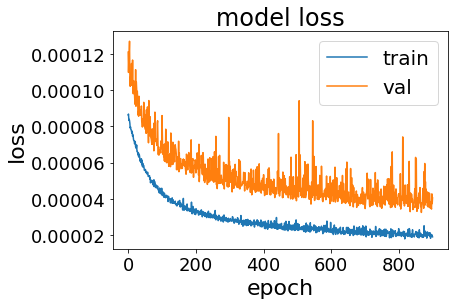

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'][100:])
plt.plot(history.history['val_loss'][100:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])#, loc='upper left')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

start = time.time()
y_train_pred = reg_best.predict(X_train_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_train, y_train_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_train, y_train_pred)
print('mae: ',mae)

r2_model = r2_score(y_train, y_train_pred)
print('\nR2: ',r2_model)

time =  -6.050654411315918

mse:  1.2270000083797807e-05
rmse:  0.003502855989588754
mae:  0.0015935707742125449

R2:  0.9999279508302825


In [26]:
start = time.time()
y_test_pred = reg_best.predict(X_test_norm)
end = time.time()
print("time = ", start - end)
print()

mse = mean_squared_error(y_test, y_test_pred)
print('mse: ',mse)
rmse = np.sqrt(mse)
print('rmse: ',rmse)
mae = mean_absolute_error(y_test, y_test_pred)
print('mae: ',mae)

r2_model = r2_score(y_test, y_test_pred)
print('\nR2: ',r2_model)

time =  -1.6744351387023926

mse:  2.4604299928336626e-05
rmse:  0.004960272162728234
mae:  0.0016660823064041826

R2:  0.9998546944436432


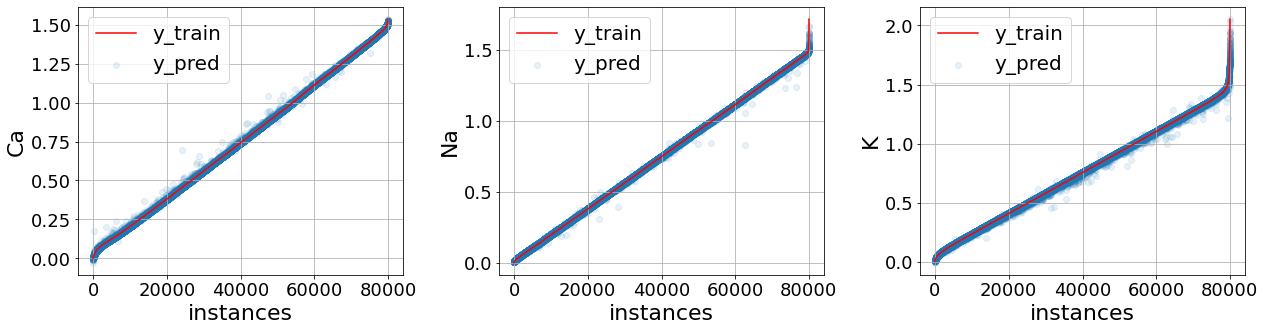

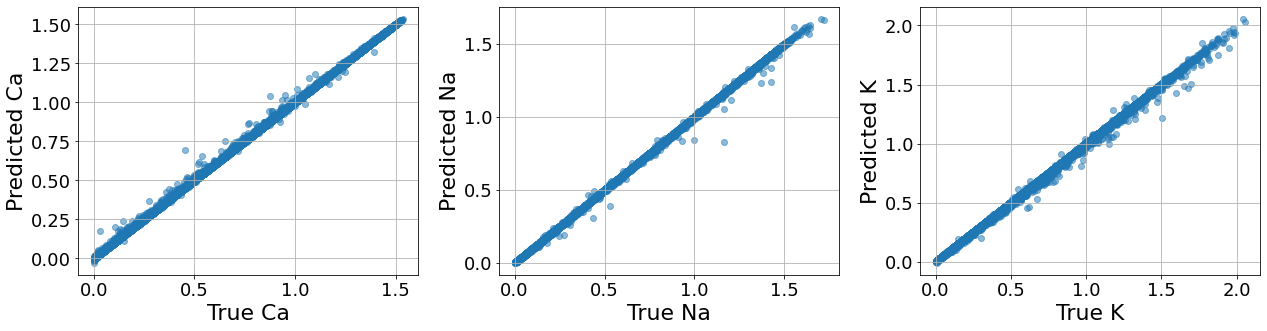

In [27]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_train[:,i]
    aux_pred = y_train_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_train[:,i], y_train_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

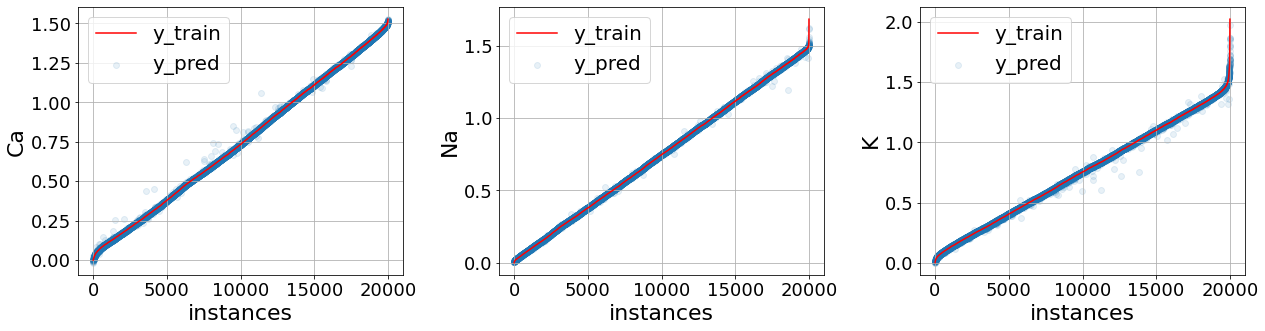

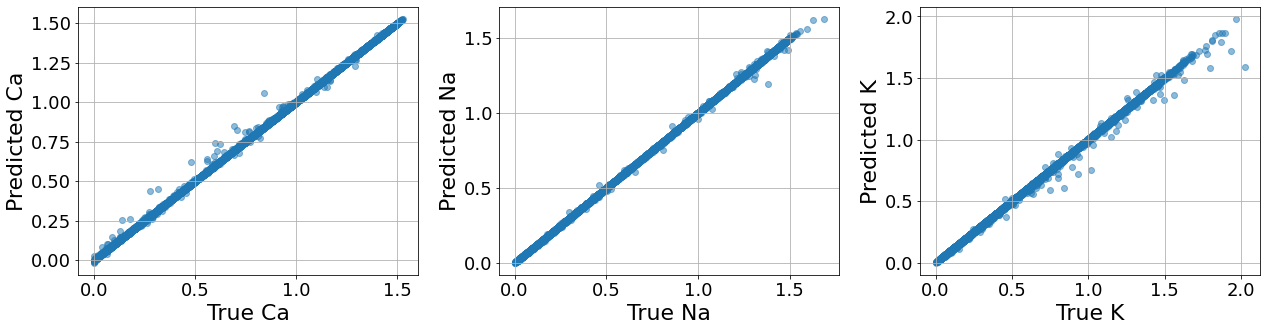

In [28]:
mpl.rcParams.update({'font.size': 20})
mpl.rc('xtick', labelsize=18) 
mpl.rc('ytick', labelsize=18) 
mpl.rc('axes', labelsize=22)
fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    aux_train = y_test[:,i]
    aux_pred = y_test_pred[:,i]
    index = np.argsort(aux_train)
    x = range(len(index))
    ax.plot(x, aux_train[index], 'r-')
    ax.scatter(x, aux_pred[index], alpha=0.1)
    ax.legend(['y_train', 'y_pred'])
    ax.set_xlabel('instances')
    ax.set_ylabel(outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

print('\n\n')

fig, axes = plt.subplots(1,3, figsize=[18,5])

for i, ax in enumerate(axes.flat):
    ax.scatter(y_test[:,i], y_test_pred[:,i], alpha=0.5)
    ax.set_xlabel('True '+outputs[i].split('_')[1])
    ax.set_ylabel('Predicted '+outputs[i].split('_')[1])
    ax.grid()
plt.tight_layout()

#### Checking charge constraint

In [29]:
charge_in = 2*X_train[:, 0]+X_train[:, 1]+X_train[:, 2]
charge_out = 2*y_train_pred[:, 0]+y_train_pred[:, 1]+y_train_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.001804942777569476

In [30]:
charge_in = 2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]
charge_out = 2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2]

mean_absolute_error(charge_in, charge_out)  

0.0018145685626571944

In [31]:
# Add Physics-constrained

#y_test_pred = NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test))
y_test_pred_con = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))
print('rmse con: ', np.sqrt(mean_squared_error(y_test, y_test_pred_con)))

rmse:  0.004960272162728234
rmse con:  0.004958854141938447


In [32]:
charge_in = 2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]
charge_out = 2*y_test_pred_con[:, 0]+y_test_pred_con[:, 1]+y_test_pred_con[:, 2]

mean_absolute_error(charge_in, charge_out)  

8.264719328849868e-08

## Run time

In [33]:
start = time.time()
for i in range(1000):  
    reg_best(X_test_norm[0:1])
end = time.time()
print("time = ", (start - end)/1000)
print()

time =  -0.0018493263721466064



## Model persistence

In [ ]:
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import load_model
#reg_best.save("NNmodel.tf", save_format="tf")
NNmodel_loaded = load_model("NNmodel.tf") 

import joblib
#joblib.dump(norm_pipeline, "norm_pipeline.pkl") 
#joblib.dump(ynorm_pipeline, "ynorm_pipeline.pkl") 
norm_pipeline_loaded = joblib.load("norm_pipeline.pkl")
#ynorm_pipeline_loaded = joblib.load("ynorm_pipeline.pkl")

print('rmse: ', np.sqrt(mean_squared_error(y_test,
                NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test)))))

2022-08-23 09:57:46.198186: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-23 09:57:47.235511: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 09:57:47.236420: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 09:57:47.267506: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-08-23 09:57:47.267541: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-23 09:57:47.269697: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

rmse:  0.004277499883103299


In [ ]:
# Add Physics-constrained

y_test_pred = NNmodel_loaded.predict(norm_pipeline_loaded.transform(X_test))
y_test_pred = (y_test_pred.T*(2*X_test[:, 0]+X_test[:, 1]+X_test[:, 2]) \
                         /(2*y_test_pred[:, 0]+y_test_pred[:, 1]+y_test_pred[:, 2])).T
print('rmse: ', np.sqrt(mean_squared_error(y_test, y_test_pred)))

rmse:  0.004958854141938447


In [ ]:
start = time.time()
NNmodel_loaded = load_model("NNmodel.tf") 
norm_pipeline_loaded = joblib.load("norm_pipeline.pkl")
#ynorm_pipeline_loaded = joblib.load("ynorm_pipeline.pkl")
end_load = time.time()
print('Load time = ', end_load - start)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:1]))
end = time.time()
print('Prediction time 1 = ', (end - start)/1000)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:1000]))
end = time.time()
print('Prediction time 1000= ', (end - start)/1000)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:10000]))
end = time.time()
print('Prediction time 10,000= ', (end - start)/1000)

Load time =  0.19106554985046387
Prediction time 1 =  0.000905475378036499
Prediction time 1000=  0.0020215492248535157
Prediction time 10,000=  0.005958674907684326


## GPU

In [ ]:
start = time.time()
NNmodel_loaded = load_model("NNmodel.tf") 
norm_pipeline_loaded = joblib.load("norm_pipeline.pkl")
#ynorm_pipeline_loaded = joblib.load("ynorm_pipeline.pkl")
end_load = time.time()
print('Load time = ', end_load - start)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:1]))
end = time.time()
print('Prediction time 1 = ', (end - start)/1000)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:1000]))
end = time.time()
print('Prediction time 1000= ', (end - start)/1000)
start =  time.time()
for i in range(1000):    
    y_pred = NNmodel_loaded(norm_pipeline_loaded.transform(X_test[0:10000]))
end = time.time()
print('Prediction time 10,000= ', (end - start)/1000)

Load time =  0.20881247520446777
Prediction time 1 =  0.0007389779090881348
Prediction time 1000=  0.0007687900066375733
Prediction time 10,000=  0.0009800443649291993
